<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w9-Data%20Augmentation/w9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pwd

In [ ]:
import os
current_path = '/content/drive/My Drive/eva5/w9-Data Augmentation/' 
os.chdir(current_path)

In [ ]:
!ls

Accuracies.png	     __init__.py  README.md	  utils
Accuracies-Quiz.png  model	  README-Quiz.md  w9.ipynb
dataset		     postproc	  req.txt	  w9_Quiz.ipynb


In [ ]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.resnet import ResNet18
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import DS_Cifar10
from dataset.download import download_cifar10

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm



### Init Device

In [ ]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [ ]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [ ]:
!nvidia-smi --query-gpu=timestamp,gpu_name,utilization.gpu,utilization.memory --format=csv

timestamp, name, utilization.gpu [%], utilization.memory [%]
2020/10/03 14:35:51.698, Tesla P4, 0 %, 0 %


### Fetch and Check the data

In [ ]:
hflip = 0.2
vflip = 0.1
rotation = 12.0

In [ ]:
DS = DS_Cifar10(path='/tmp', hflip = 0.2, vflip = 0.1,rotation = 12.0)
Classes = DS.classes

path /tmp
Files already downloaded and verified
Transformations
{'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp
Files already downloaded and verified
Transformations
{'train': False, 'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp
Files already downloaded and verified


### Data Loaders

In [ ]:
train_loader = DS.loader(batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)
test_loader = DS.loader(train = False, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)

{'batch_size': 64, 'num_workers': 64, 'cuda': True}
train True
{'train': False, 'batch_size': 64, 'num_workers': 64, 'cuda': True}
train False


In [ ]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = ResNet18().to(dev)

In [ ]:
image_size = DS.image_size
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

EPOCHS = 25
LEARNING_RATE = 0.01
MOMENTUM = 0.9
SAMPLE_COUNT = 25


losses = []
accuracies = []
incorrect_samples = []
correct_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, LEARNING_RATE, MOMENTUM)  # Create optimizer

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = StepLR(optimizer, step_size=10, gamma=0.3)

for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion)
    scheduler.step()
    val(
        model, test_loader, dev, criterion, losses, accuracies,
        correct_samples, incorrect_samples, SAMPLE_COUNT, epoch,EPOCHS
    )

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  4%|▍         | 1/25 [01:09<27:50, 69.62s/it]


Validation set: Average loss: 0.0188, Accuracy: 6034/10000 (60.34%)

Epoch 2:


  8%|▊         | 2/25 [02:20<26:47, 69.89s/it]


Validation set: Average loss: 0.0119, Accuracy: 7407/10000 (74.07%)

Epoch 3:


 12%|█▏        | 3/25 [03:31<25:45, 70.25s/it]


Validation set: Average loss: 0.0100, Accuracy: 7857/10000 (78.57%)

Epoch 4:


 16%|█▌        | 4/25 [04:42<24:39, 70.46s/it]


Validation set: Average loss: 0.0095, Accuracy: 7958/10000 (79.58%)

Epoch 5:


 20%|██        | 5/25 [05:53<23:32, 70.63s/it]


Validation set: Average loss: 0.0096, Accuracy: 8028/10000 (80.28%)

Epoch 6:


 24%|██▍       | 6/25 [07:04<22:27, 70.94s/it]


Validation set: Average loss: 0.0095, Accuracy: 8176/10000 (81.76%)

Epoch 7:


 28%|██▊       | 7/25 [08:16<21:19, 71.08s/it]


Validation set: Average loss: 0.0091, Accuracy: 8297/10000 (82.97%)

Epoch 8:


 32%|███▏      | 8/25 [09:27<20:08, 71.08s/it]


Validation set: Average loss: 0.0099, Accuracy: 8222/10000 (82.22%)

Epoch 9:


 36%|███▌      | 9/25 [10:38<18:56, 71.02s/it]


Validation set: Average loss: 0.0090, Accuracy: 8323/10000 (83.23%)

Epoch 10:


 40%|████      | 10/25 [11:49<17:45, 71.01s/it]


Validation set: Average loss: 0.0092, Accuracy: 8390/10000 (83.90%)

Epoch 11:


 44%|████▍     | 11/25 [13:00<16:34, 71.01s/it]


Validation set: Average loss: 0.0075, Accuracy: 8676/10000 (86.76%)

Epoch 12:


 48%|████▊     | 12/25 [14:11<15:23, 71.00s/it]


Validation set: Average loss: 0.0076, Accuracy: 8697/10000 (86.97%)

Epoch 13:


 52%|█████▏    | 13/25 [15:22<14:12, 71.04s/it]


Validation set: Average loss: 0.0077, Accuracy: 8750/10000 (87.50%)

Epoch 14:


 56%|█████▌    | 14/25 [16:33<13:02, 71.14s/it]


Validation set: Average loss: 0.0078, Accuracy: 8712/10000 (87.12%)

Epoch 15:


 60%|██████    | 15/25 [17:45<11:53, 71.37s/it]


Validation set: Average loss: 0.0078, Accuracy: 8725/10000 (87.25%)

Epoch 16:


 64%|██████▍   | 16/25 [18:56<10:41, 71.32s/it]


Validation set: Average loss: 0.0083, Accuracy: 8726/10000 (87.26%)

Epoch 17:


 68%|██████▊   | 17/25 [20:08<09:30, 71.28s/it]


Validation set: Average loss: 0.0081, Accuracy: 8718/10000 (87.18%)

Epoch 18:


 72%|███████▏  | 18/25 [21:19<08:18, 71.26s/it]


Validation set: Average loss: 0.0080, Accuracy: 8778/10000 (87.78%)

Epoch 19:


 76%|███████▌  | 19/25 [22:30<07:07, 71.27s/it]


Validation set: Average loss: 0.0083, Accuracy: 8717/10000 (87.17%)

Epoch 20:


 80%|████████  | 20/25 [23:41<05:56, 71.28s/it]


Validation set: Average loss: 0.0085, Accuracy: 8732/10000 (87.32%)

Epoch 21:


 84%|████████▍ | 21/25 [24:52<04:44, 71.20s/it]


Validation set: Average loss: 0.0083, Accuracy: 8762/10000 (87.62%)

Epoch 22:


 88%|████████▊ | 22/25 [26:03<03:33, 71.18s/it]


Validation set: Average loss: 0.0081, Accuracy: 8747/10000 (87.47%)

Epoch 23:


 92%|█████████▏| 23/25 [27:16<02:22, 71.43s/it]


Validation set: Average loss: 0.0080, Accuracy: 8778/10000 (87.78%)

Epoch 24:


 96%|█████████▌| 24/25 [28:27<01:11, 71.57s/it]


Validation set: Average loss: 0.0080, Accuracy: 8765/10000 (87.65%)

Epoch 25:


100%|██████████| 25/25 [29:42<00:00, 71.29s/it]


Validation set: Average loss: 0.0080, Accuracy: 8770/10000 (87.70%)



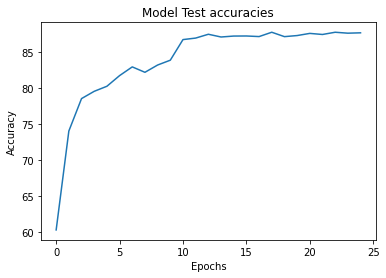

In [ ]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Test accuracies')
plt.savefig('Accuracies.png')
plt.show()

In [ ]:
import random
# importlib.reload(gradcam)

from postproc.gradcam import GradCAMOverlay

grad_cam = GradCAMOverlay(
    model, ['layer_1', 'layer_2', 'layer_3', 'layer_4'],
    dev, DS.mean, DS.std
)



intent layer 1
intent layer 2
intent layer 3
intent layer 4
intent layer 1
intent layer 2
intent layer 3
intent layer 4
GradCam Init...


In [ ]:
from pathlib import Path
Path(current_path+'/output').mkdir(parents=True, exist_ok=True)



### GradCAM Positive Images



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


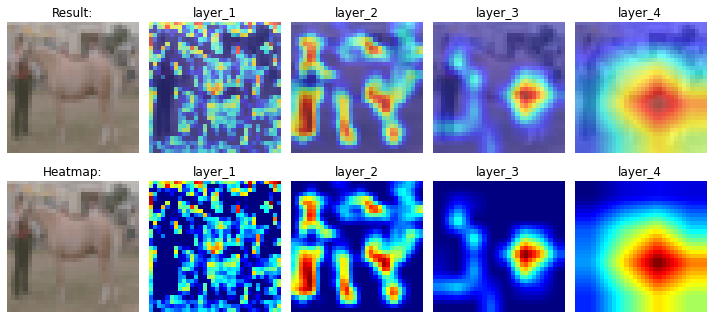

<Figure size 432x288 with 0 Axes>

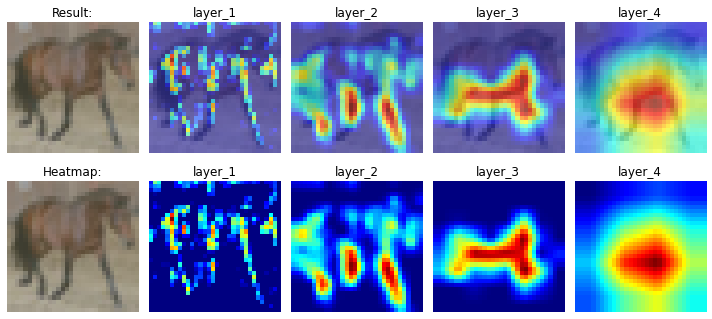

<Figure size 432x288 with 0 Axes>

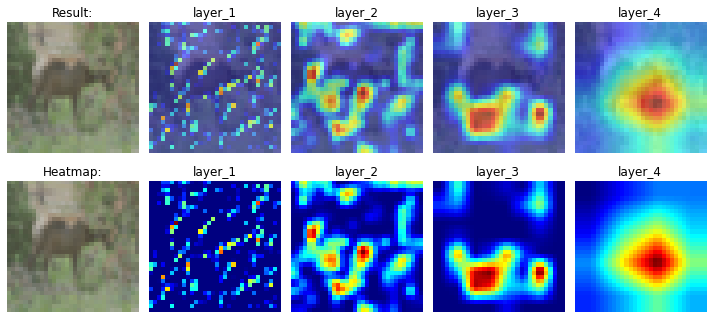

<Figure size 432x288 with 0 Axes>

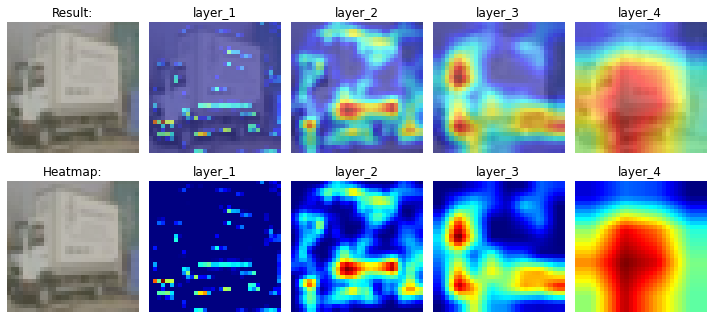

<Figure size 432x288 with 0 Axes>

In [ ]:
correct_im_prefix = 'Correct_grad_cam'

images = [x['image'] for x in random.sample(correct_samples, 4)]
grad_cam(images, current_path+'/output/'+correct_im_prefix)

### GradCAM Negative Images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


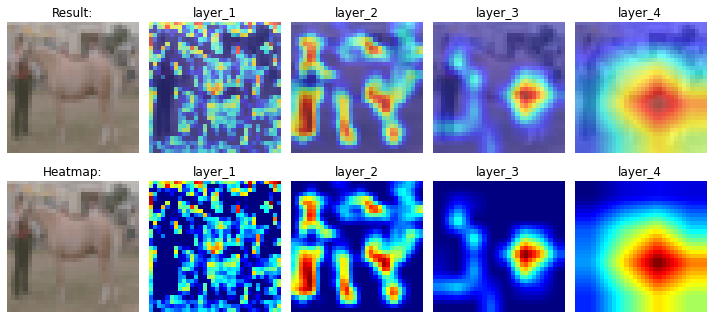

<Figure size 432x288 with 0 Axes>

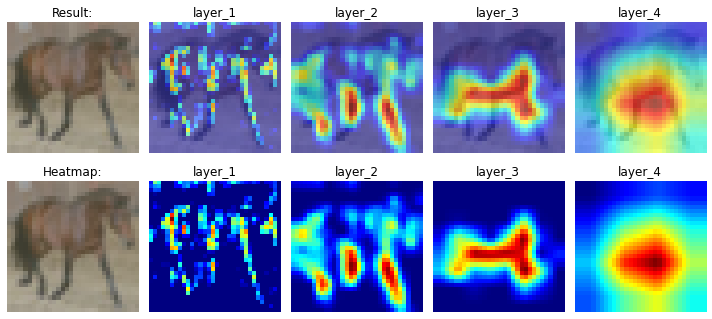

<Figure size 432x288 with 0 Axes>

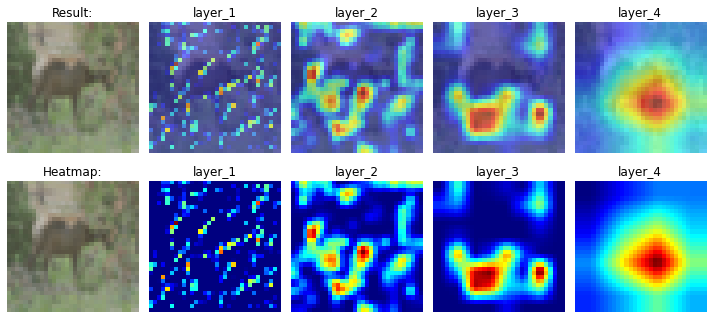

<Figure size 432x288 with 0 Axes>

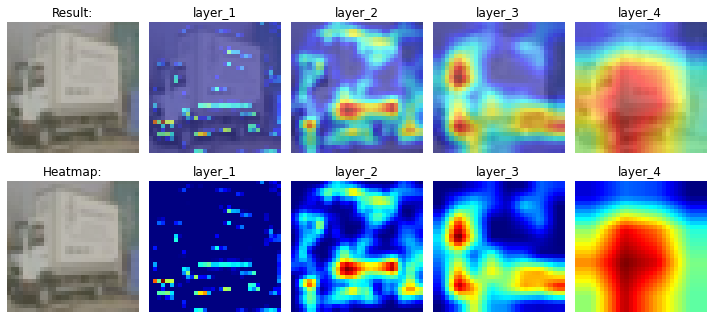

<Figure size 432x288 with 0 Axes>

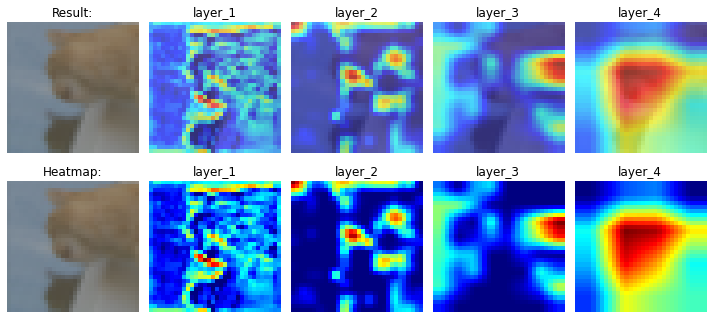

<Figure size 432x288 with 0 Axes>

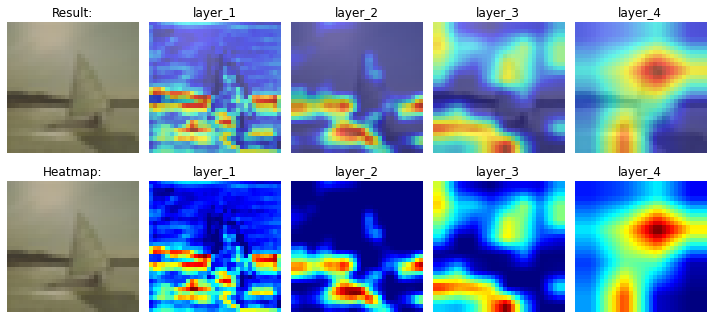

<Figure size 432x288 with 0 Axes>

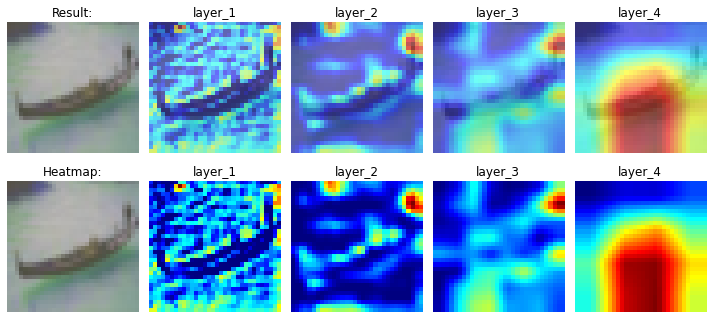

<Figure size 432x288 with 0 Axes>

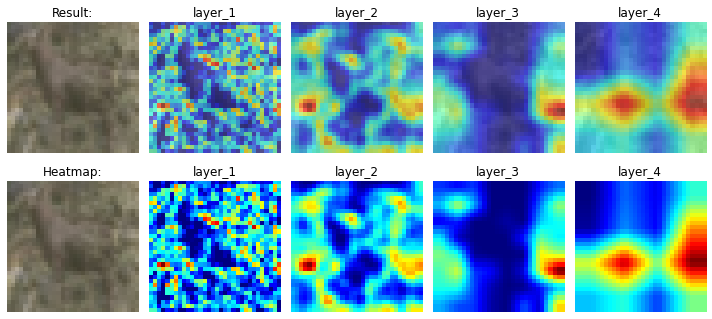

<Figure size 432x288 with 0 Axes>

In [ ]:
incorrect_im_prefix = 'Incorrect_grad_cam'
images = [x['image'] for x in random.sample(incorrect_samples, 4)]
grad_cam(images,current_path+'/output/'+incorrect_im_prefix)

In [ ]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [ ]:
readme = f'''

# Data Augmentation | GradCAM
This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch,
and uses GradCAM analysis for model explanation  to explain which layer of model was activated for the give image

Here we use Data Augmentation implementusing [Albumentations](https://github.com/albumentations-team/albumentations) library

The results with using ResNet18 architecture with (2,2,2,2), that is, 4 residual blocks of size 2 each.
 
----
| Attribute | Value |
|:--- | :--- |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|

----

![](Accuracies.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

To run 

You can install dependencies using  
`$ pip install -r req.txt`


###Grad CAM Images

'''

from utils import filelist
correct_files = filelist(current_path+'/output', correct_im_prefix)
incorrect_files = filelist(current_path+'/output', incorrect_im_prefix)
readme += '####Correct Images'

for idx,f in enumerate(correct_files):
  if not idx%4:
    readme+=' </br> '
  readme += f'''![]({f})'''

readme += '''

-----

'''
readme += '####Incorrect Images'
for idx,f in enumerate(incorrect_files):
  if not idx%4:
    readme+=' </br> '
  readme += f'''![]({f})'''

with open('README.md', 'w') as f:
    f.write(readme)

In [ ]:
!pip install -q -r req.txt